In [3]:
import numpy as np
from library_dicom.dicom_processor.tools.create_mip import *
import matplotlib.pyplot as plt
from radiomics.featureextractor import *
from sklearn import mixture

from library_dicom.post_processing.PostProcess_Reader import PostProcess_Reader
from library_dicom.post_processing.Mask4D import Mask4D
from library_dicom.post_processing.GaussianModel import GaussianModel

In [76]:
import SimpleITK as sitk  
mask_path = r'C:\Users\wendy\Documents\STAGE\gained\1.2.250.1.74.20130607110000.4000014017745_nifti_mask.nii'
pet_path = r'C:\Users\wendy\Documents\STAGE\gained\1.2.250.1.74.20130607110000.4000014017745_nifti_PT.nii'

In [77]:
model = PostProcess_Reader(mask_path, pet_path, type = '4d')

for i in range(1,22) : 
    x,y,z = np.where(mask == i)
    new_mask_3D = np.zeros((169, 169, 255))
    for j in range(len(x)): 

        new_mask_3D[x[j], y[j], z[j]] = 10
    mip_imshow(new_mask_3D, 0)

In [4]:
import SimpleITK as sitk 

In [ ]:
#2 MOYENS POUR LABELLISE MASK BINAIRE

In [ ]:
#SCIKIT LEARN LABEL

In [78]:
model.number_of_label

15

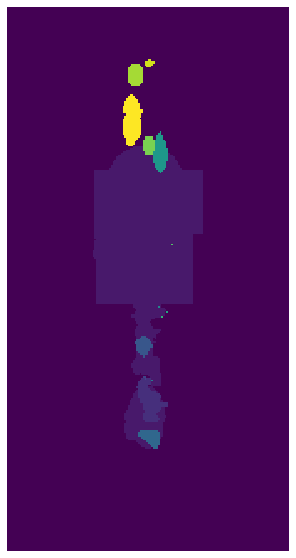

In [79]:
mip_imshow(model.labelled_mask, 0, 'viridis', 'mask')

In [ ]:
#SIMPLE ITK CONNECTED COMPONENT

In [80]:
labelled = sitk.ConnectedComponent(model.binary_mask_img)

In [81]:
stats = sitk.LabelIntensityStatisticsImageFilter()
stats.Execute(labelled, model.pet_img)

In [82]:
stats.GetLabels()

(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15)

In [83]:
for label in stats.GetLabels() : 
    print('label : {}, number_pixels : {}, centroid : {}'.format(label, stats.GetNumberOfPixels(label), stats.GetCentroid(label)))

label : 1, number_pixels : 198429, centroid : (34.92018185253306, -189.55100165168062, -921.4767624691956)
label : 2, number_pixels : 398, centroid : (-17.036884250353353, -172.6488218834652, -1282.429648241206)
label : 3, number_pixels : 954, centroid : (-49.04620687616699, -176.86296521392757, -1217.8616352201257)
label : 4, number_pixels : 1, centroid : (-32.959808349609375, -170.95010375976562, -1181.5)
label : 5, number_pixels : 3, centroid : (-53.32395935058594, -188.59903462727863, -1176.5)
label : 6, number_pixels : 327, centroid : (-37.842222534553, -192.4601274776167, -1119.7844036697247)
label : 7, number_pixels : 1, centroid : (19.986984252929688, -146.51312255859375, -1067.5)
label : 8, number_pixels : 1, centroid : (-4.4499969482421875, -134.2946319580078, -1058.5)
label : 9, number_pixels : 1, centroid : (-12.595657348632812, -154.65878295898438, -1049.5)
label : 10, number_pixels : 1, centroid : (24.059814453125, -122.07614135742188, -938.5)
label : 11, number_pixels : 

In [12]:
sitk.Image.TransformPhysicalPointToIndex(labelled, stats.GetCentroid(1 ))

(83, 88, 185)

In [84]:
array_1 = sitk.GetArrayFromImage(labelled).transpose()

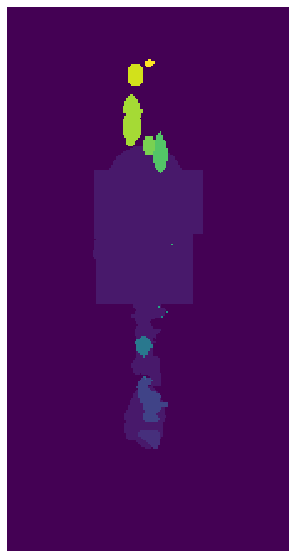

In [85]:
mip_imshow(array_1, 0, cmap = 'viridis', type='mask')

In [16]:
array_1.shape

(168, 168, 390)

for i in range(1,4) : 
    x,y,z = np.where(array_1 == i) 
    new_mask_3D = np.zeros((168, 168, 390)) 
    
    for j in range(len(x)):
        new_mask_3D[x[j], y[j], z[j]] = i

    mip_imshow(new_mask_3D, 0, cmap='Greys', type = 'mask')

In [ ]:
#MASK 4D IMSHOW ET MASK BINAIRE 3D IMSHOW 

In [86]:
mask = sitk.ReadImage(mask_path)
mask_array = sitk.GetArrayFromImage(mask).transpose()
mask_array.shape

(168, 168, 324, 59)

for i in range(5):
    mip_imshow(mask_array[:,:,:,i], 0, cmap='Greys', type = 'mask')

mip_imshow_4D(mask_array, 0, cmap = 'Blues')

In [87]:
pet = sitk.ReadImage(pet_path)
pet_array = sitk.GetArrayFromImage(pet).transpose()
pet_array.shape

(168, 168, 324)

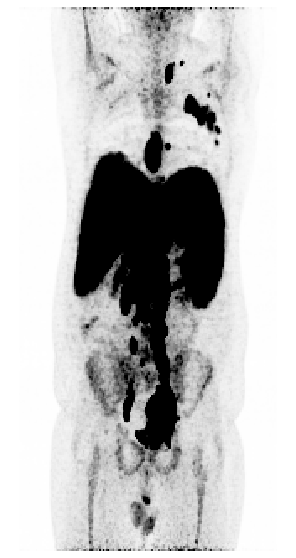

In [88]:
mip_imshow(pet_array, 270, 'Greys', 'tep')

In [103]:
#superposer TEP et MIP 
mask = sitk.ReadImage(mask_path)
mask_array = sitk.GetArrayFromImage(mask).transpose()
mask_array.shape

(168, 168, 324, 59)

In [105]:
#treshold mask 

for i in range(mask_array.shape[3]):
    x,y,z = np.where(mask_array[:,:,:,i] != 0)
    suv_values = []
    for j in range(len(x)):
        suv_values.append(pet_array[x[j], y[j], z[j]])

    maxi = np.max(suv_values)
    seuil = maxi * 0.41

    for a,b,c in zip(x,y,z) :
        if pet_array[a,b,c] <= seuil :
            mask_array[a,b,c,i] = 0

In [106]:
#reunite in 3D
shape_mask = mask_array.shape
binary_mask = np.zeros((shape_mask[0], shape_mask[1], shape_mask[2]))
sum_mask = np.ndarray.sum(mask_array, axis = -1)
binary_mask[np.where(sum_mask != 0)] = 1
binary_mask = binary_mask.astype(np.uint8)

In [107]:
binary_mask.shape

(168, 168, 324)

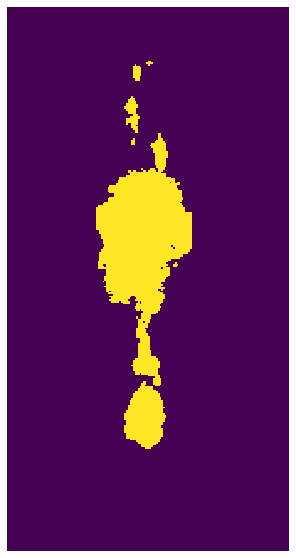

In [230]:
mip_imshow(binary_mask, 0, cmap = 'viridis', type ='mask')

In [109]:
direction = model.pet_direction
origin = model.pet_origin
spacing = model.pet_spacing
labelled_img = sitk.GetImageFromArray(binary_mask.transpose())
labelled_img.SetDirection(direction)
labelled_img.SetOrigin(origin)
labelled_img.SetSpacing(spacing)

In [110]:
labelled_img.GetSize()

(168, 168, 324)

In [111]:
model.pet_img.GetSize()

(168, 168, 324)

In [112]:
labelled_seuil = sitk.ConnectedComponent(labelled_img)
stats = sitk.LabelIntensityStatisticsImageFilter()
stats.Execute(labelled_seuil, sitk.ReadImage(pet_path))

In [113]:
stats.GetNumberOfLabels()

53

In [114]:
volume_voxel = model.pet_spacing[0] * model.pet_spacing[1] * model.pet_spacing[2] * 10**(-3)
volume_voxel

0.04976383751886897

In [115]:
for i in range(1, stats.GetNumberOfLabels() + 1) : 
    print('label : {}, volume = {}'.format(i, stats.GetNumberOfPixels(i) * volume_voxel))

label : 1, volume = 270.8148037776849
label : 2, volume = 5.523785964594455
label : 3, volume = 9.15654610347189
label : 4, volume = 1.6422066381226759
label : 5, volume = 515.3045375078882
label : 6, volume = 3.9811070015095176
label : 7, volume = 0.9952767503773794
label : 8, volume = 0.09952767503773793
label : 9, volume = 0.34834686263208275
label : 10, volume = 0.04976383751886897
label : 11, volume = 1273.6058936204136
label : 12, volume = 2.5379557134623174
label : 13, volume = 1321.3791776385276
label : 14, volume = 0.19905535007547587
label : 15, volume = 0.9455129128585104
label : 16, volume = 0.04976383751886897
label : 17, volume = 0.04976383751886897
label : 18, volume = 0.5474022127075586
label : 19, volume = 0.6966937252641655
label : 20, volume = 0.09952767503773793
label : 21, volume = 0.04976383751886897
label : 22, volume = 0.09952767503773793
label : 23, volume = 15.227734280773904
label : 24, volume = 0.04976383751886897
label : 25, volume = 1.9905535007547588
labe

for i in range(1,stats.GetNumberOfLabels() + 1): 
    new_mask = np.zeros((168, 168, 324))
    x,y,z = np.where(sitk.GetArrayFromImage(labelled_seuil).transpose() == i)

    for j in range(len(x)):
        new_mask[x[j], y[j], z[j]] = i

    mip_imshow(new_mask, 90, cmap = 'viridis', type = 'mask')

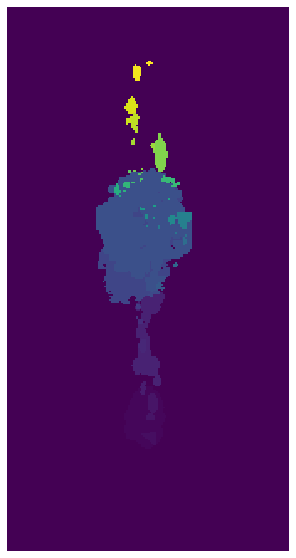

In [117]:
mip_imshow(sitk.GetArrayFromImage(labelled_seuil).transpose(), 0, cmap = 'viridis', type = 'mask')

In [212]:
numero_labels = []
for i in range(1, stats.GetNumberOfLabels() + 1) : 
    if stats.GetNumberOfPixels(i) * volume_voxel > float(30) :
        numero_labels.append(i)

In [213]:
numero_labels

[1, 5, 11, 13, 43]

In [196]:
#LABEL 1

In [232]:
new_mask_3D_1 = np.zeros((168,168,324))
new_mask_3D_1[np.where(labelled_seuil_array == 1)] = model.pet_array[np.where(labelled_seuil_array == 1)]

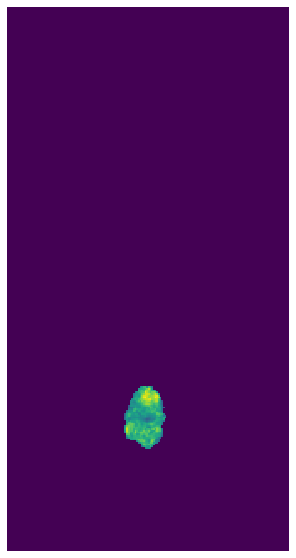

In [233]:
mip_imshow(new_mask_3D_1, 0, cmap = 'viridis', type = 'mask' )

In [234]:
D = ndimage.distance_transform_edt(new_mask_3D_1)
D.shape

(168, 168, 324)

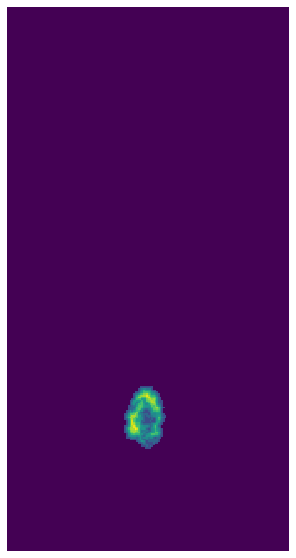

In [235]:
mip_imshow(D, 0, cmap = 'viridis', type = 'mask')

In [236]:
from skimage.feature import peak_local_max
localMax = peak_local_max(D, indices = True, min_distance=15)
localMax2 = peak_local_max(D, indices = False, min_distance=15)

In [237]:
localMax

array([[94, 83, 92],
       [92, 76, 72]], dtype=int64)

In [238]:
marker_array = np.zeros((168, 168, 324))
for marker in range(len(localMax)) : 
    print(marker)
    marker_array[localMax[marker][0], localMax[marker][1], localMax[marker][2]] = marker + 1


0
1


In [239]:
import skimage as sk

labels = sk.morphology.watershed(-D,marker_array,mask=new_mask_3D_1)

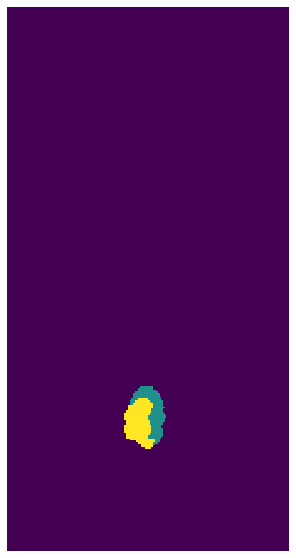

In [240]:
mip_imshow(labels, 0, cmap = 'viridis', type='mask')

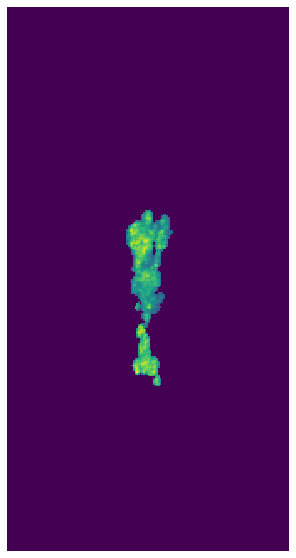

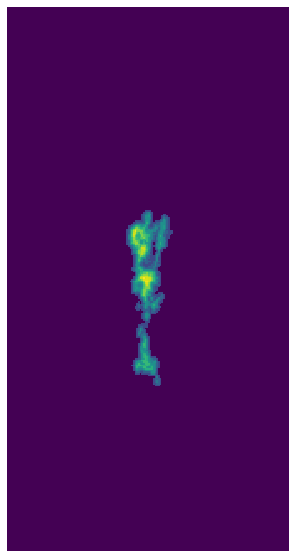

6


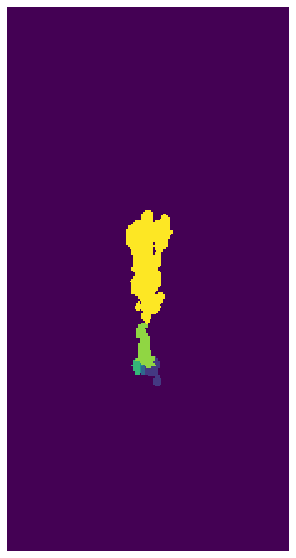

In [242]:
#LABEL 5 
new_mask_3D_5 = np.zeros((168,168,324))
new_mask_3D_5[np.where(labelled_seuil_array == 5)] = model.pet_array[np.where(labelled_seuil_array == 5)]
mip_imshow(new_mask_3D_5, 0, cmap = 'viridis', type = 'mask' )
D = ndimage.distance_transform_edt(new_mask_3D_5)
mip_imshow(D, 0, cmap = 'viridis', type = 'mask')

localMax = peak_local_max(D, indices = True, min_distance=40)
localMax2 = peak_local_max(D, indices = False, min_distance=40)

print(len(localMax))

marker_array = np.zeros((168, 168, 324))
for marker in range(len(localMax)) : 
    #print(marker)
    marker_array[localMax[marker][0], localMax[marker][1], localMax[marker][2]] = marker + 1

labels = sk.morphology.watershed(-D,marker_array,mask=new_mask_3D_5)
mip_imshow(labels, 0, cmap = 'viridis', type='mask')

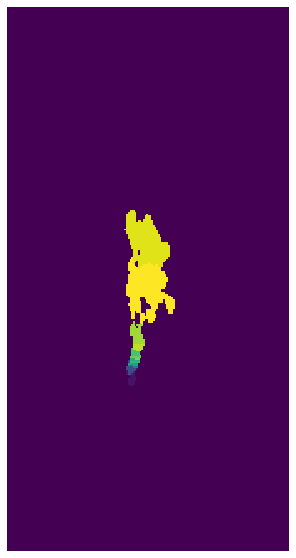

In [228]:
mip_imshow(labels, 90, cmap = 'viridis', type='mask')

In [260]:
pet_array[np.where(binary_mask == 0)] = 0

26


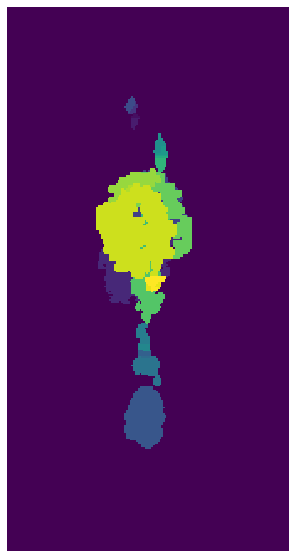

In [262]:
#tep entier
D = ndimage.distance_transform_edt(pet_array)
#mip_imshow(D, 0, cmap = 'viridis', type = 'mask')

localMax = peak_local_max(D, indices = True, min_distance=20)
localMax2 = peak_local_max(D, indices = False, min_distance=20)

print(len(localMax))

marker_array = np.zeros((168, 168, 324))
for marker in range(len(localMax)) : 
    #print(marker)
    marker_array[localMax[marker][0], localMax[marker][1], localMax[marker][2]] = marker + 1

labels = sk.morphology.watershed(-D,marker_array,mask=pet_array)

#labels[np.where(binary_mask == 0)] = 0
mip_imshow(labels, 0, cmap = 'viridis', type='mask')

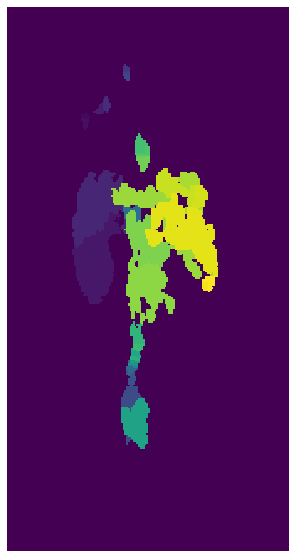

In [251]:
mip_imshow(labels, 90, cmap = 'viridis', type='mask')

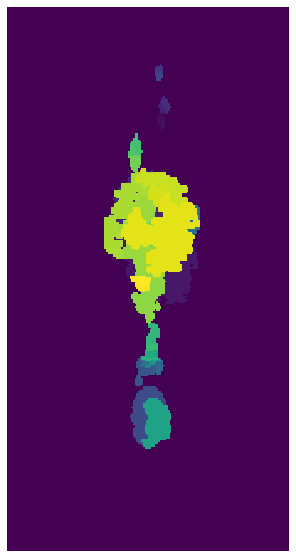

In [252]:
mip_imshow(labels, 180, cmap = 'viridis', type='mask')

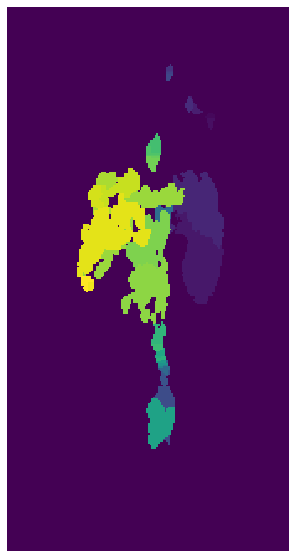

In [253]:
mip_imshow(labels, 270, cmap = 'viridis', type='mask')

In [ ]:
#WATERSHED

In [20]:
ws = sitk.MorphologicalWatershedFromMarkers(model.pet_img, model.labelled_mask_img, markWatershedLine=True, fullyConnected= False)

In [21]:
array = sitk.GetArrayFromImage(ws).transpose()

In [22]:
array.shape

(169, 169, 255)

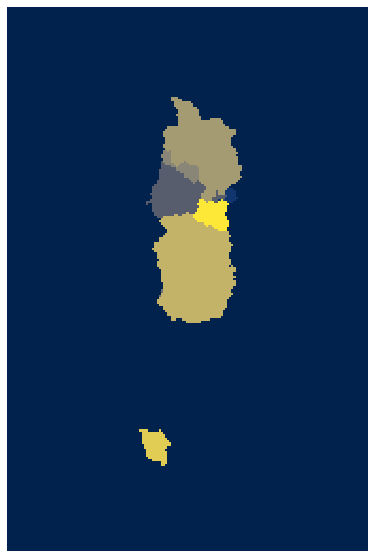

In [23]:
mip_imshow(array, 0)

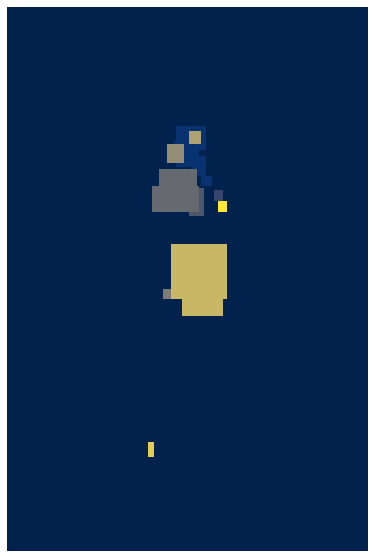

In [41]:
mip_imshow(model.labelled_mask, 0)